<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
#from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


^C


### Task 2: Plot Sample Image

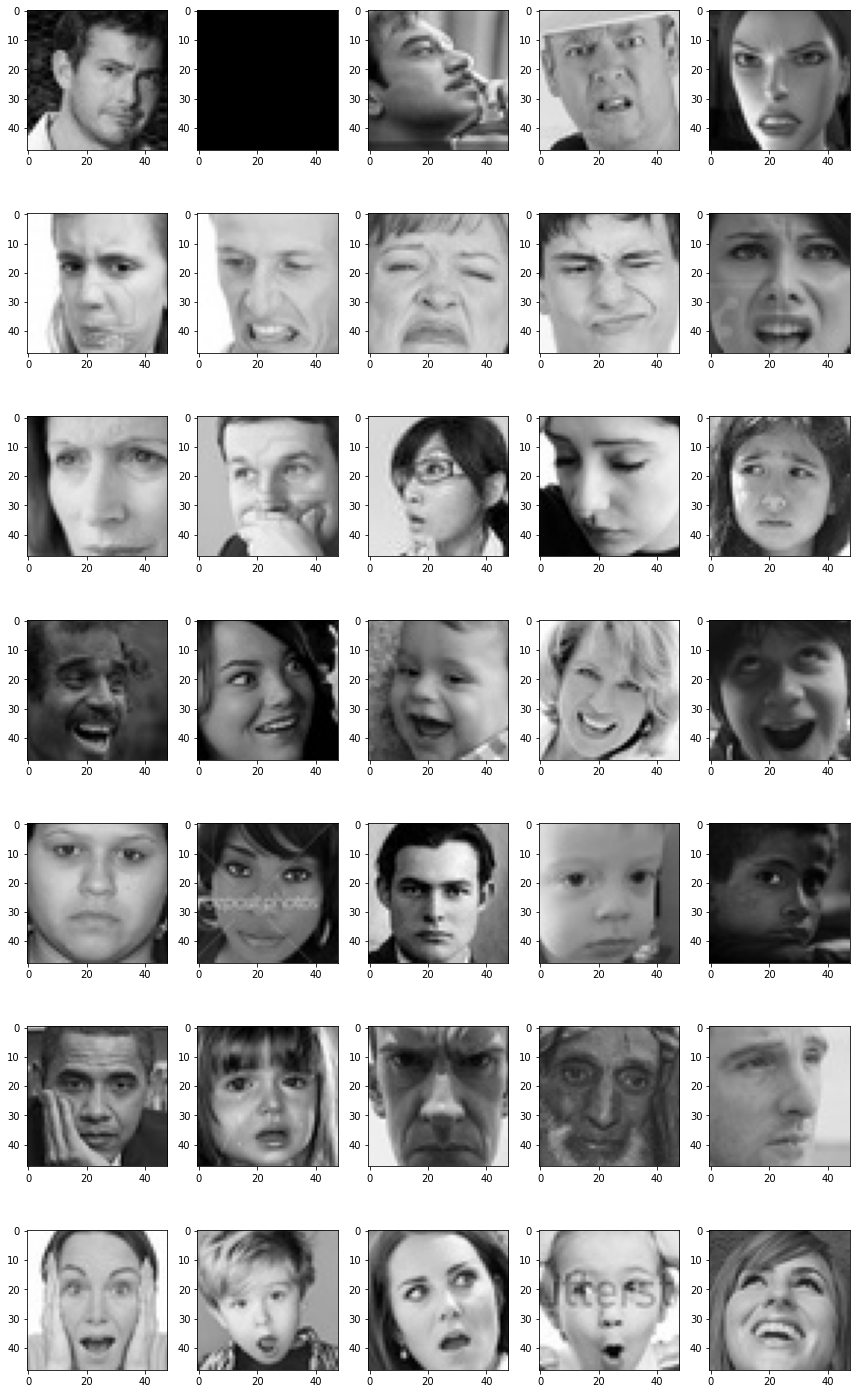

In [2]:
utils.datasets.fer.plot_example_images(plt).show()

# EDA
## Check if data is balanced

In [3]:
# loop through all folders and check how many images we have for each class
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + "images")

3995 angryimages
436 disgustimages
4097 fearimages
7215 happyimages
4965 neutralimages
4830 sadimages
3171 surpriseimages


### Task 3: Generate Training and Validation Batches

In [4]:
img_size = 48
batch_size = 64

# dat augmentation technique:
datagen_train = ImageDataGenerator(horizontal_flip= True)
train_generator = datagen_train.flow_from_directory("train/", target_size=(img_size, img_size), color_mode="grayscale", batch_size=batch_size, class_mode="categorical", shuffle=True)


datagen_validation = ImageDataGenerator(horizontal_flip= True)
validation_generator = datagen_validation.flow_from_directory("test/", target_size=(img_size, img_size), color_mode="grayscale", batch_size=batch_size, class_mode="categorical", shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)



In [5]:
model = Sequential()

# 1 - conv
model.add(Conv2D(64, (3,3), padding = "same", input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 - conv layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 - conv layer
model.add(Conv2D(518, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4 - conv layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Task 6: Train and Evaluate Model

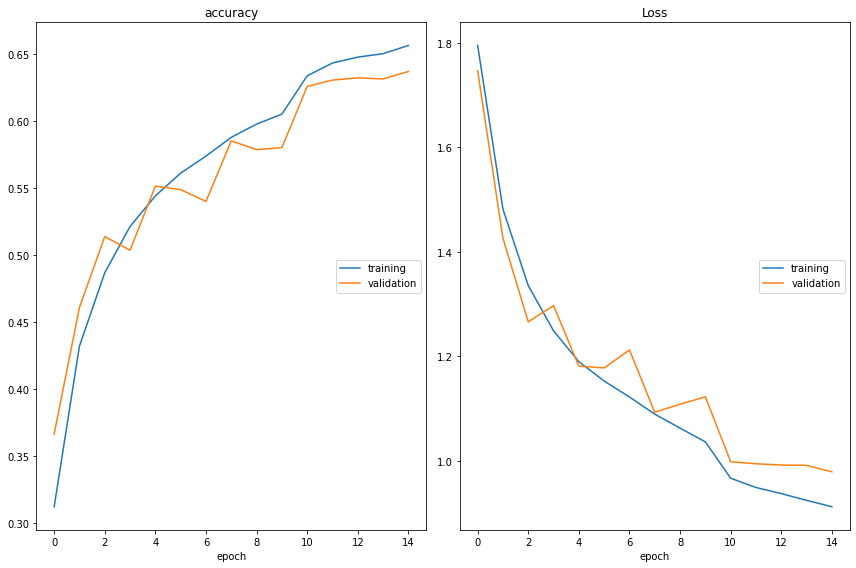

accuracy
	training         	 (min:    0.312, max:    0.657, cur:    0.657)
	validation       	 (min:    0.367, max:    0.637, cur:    0.637)
Loss
	training         	 (min:    0.912, max:    1.795, cur:    0.912)
	validation       	 (min:    0.979, max:    1.747, cur:    0.979)

Epoch 00015: saving model to model_weights.h5


In [6]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=0.00001, model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x = train_generator,
steps_per_epoch=steps_per_epoch,
epochs=epochs,
validation_data=validation_generator,
validation_steps=validation_steps,
callbacks=callbacks)

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Task 7: Represent Model as JSON String

In [7]:
model_json = model.to_json()

with open("model.json", 'w') as json_file:
    json_file.write(model_json)